# Crash Inequality Analysis Across Chicago Communities

This notebook analyzes crash inequality across Chicago's 77 community areas, examining:
1. Crash rates by community area
2. Relationship between demographics and crash exposure
3. Severity patterns across income levels
4. Statistical tests for disparities

**Key Question**: Are crashes and severe injuries distributed equally across neighborhoods, or do certain communities bear a disproportionate burden?

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)
sns.set_style('whitegrid')

# Paths
DATA_DIR = Path('../data/processed')
RESULTS_DIR = Path('../results')
RESULTS_DIR.mkdir(exist_ok=True)

## 1. Load Data

In [37]:
# Load intersection features with demographics and community areas
feats = pd.read_parquet(DATA_DIR / 'intersection_features_enriched.parquet')

# Load crashes for temporal analysis
crashes = pd.read_parquet(DATA_DIR / 'crashes_with_nodes.parquet')

# Validation checks
assert len(feats) > 15000, "❌ Too few intersections"
assert 'community_name' in feats.columns, "❌ Missing community_name column"
assert crashes['intersection_id'].notna().mean() > 0.85, "❌ Low match rate"

print("✅ Data validation passed")
print(f"Intersections: {len(feats):,}")
print(f"Total crashes: {len(crashes):,}")
print(f"Matched crashes: {crashes['intersection_id'].notna().sum():,} ({crashes['intersection_id'].notna().mean()*100:.1f}%)")
print(f"Communities: {feats['community_name'].nunique()}")

# Check for injury columns
injury_pattern = [col for col in feats.columns if 'injuries' in col]
print(f"\nAvailable injury columns ({len(injury_pattern)}):")
for col in injury_pattern:
    print(f"  - {col}")

feats.head()

✅ Data validation passed
Intersections: 19,200
Total crashes: 1,001,020
Matched crashes: 880,457 (88.0%)
Communities: 78

Available injury columns (8):
  - hist_people_injuries_total
  - hist_people_injuries_fatal
  - hist_people_injuries_incapacitating
  - hist_people_injuries_nonincap
  - recent90_people_injuries_total
  - recent90_people_injuries_fatal
  - recent90_people_injuries_incapacitating
  - recent90_people_injuries_nonincap


,intersection_id,hist_crashes,hist_severity,recent90_crashes,recent90_severity,future_crashes,future_severity,centrality_degree,centrality_closeness,label_hotspot,GEOID,acs_pop,acs_median_income,acs_households_with_vehicle,acs_poverty_universe,acs_vehicle_access_rate,hist_people_injuries_total,hist_people_injuries_fatal,hist_people_injuries_incapacitating,hist_people_injuries_nonincap,recent90_people_injuries_total,recent90_people_injuries_fatal,recent90_people_injuries_incapacitating,recent90_people_injuries_nonincap,centrality_betweenness,community_id,community_name,acs_pop_missing,acs_median_income_missing,acs_households_with_vehicle_missing,acs_poverty_universe_missing,acs_vehicle_access_rate_missing
0,25779174.0,7,7.0,1.0,1.0,0.0,0.0,0.000102,0.023397,0,17031243500,4567.0,160370.0,454.0,4567.0,0.099409,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.172562,24.0,WEST TOWN,0,0,0,0,0
1,25779203.0,3,3.0,0.0,0.0,1.0,3.0,0.000102,0.022747,0,17031310200,1824.0,133382.0,114.0,1817.0,0.062500,4.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.219941,31.0,LOWER WEST SIDE,0,0,0,0,0
2,25779221.0,1,1.0,0.0,0.0,1.0,3.0,0.000102,0.023321,0,17031843200,2348.0,66172.0,196.0,2342.0,0.083475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106616,31.0,LOWER WEST SIDE,0,0,0,0,0
3,26098008.0,1,1.0,0.0,0.0,0.0,0.0,0.000102,0.023858,0,17031841000,1148.0,103750.0,176.0,1148.0,0.153310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032626,33.0,NEAR SOUTH SIDE,0,0,0,0,0
4,26098027.0,1,1.0,0.0,0.0,0.0,0.0,0.000102,0.021226,0,17031841100,6990.0,48542.0,1247.0,6990.0,0.178398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007880,34.0,ARMOUR SQUARE,0,0,0,0,0


## 2. Community-Level Aggregation

In [38]:
# Check which columns are available
print("Available columns in dataset:")
print(feats.columns.tolist())
print("\n")

# Build aggregation dict based on available columns
agg_dict = {
    'intersection_id': 'count',
    'hist_crashes': 'sum',
    'hist_severity': 'sum',
    'future_crashes': 'sum',
    'label_hotspot': 'sum',
    'acs_pop': 'mean',
    'acs_median_income': 'mean',
    'acs_vehicle_access_rate': 'mean',
    'acs_poverty_universe': 'mean',
}

# Add injury columns if they exist (FIXED: correct column names with "people")
injury_cols = [
    'hist_people_injuries_total',
    'hist_people_injuries_fatal', 
    'hist_people_injuries_incapacitating',
    'hist_people_injuries_nonincap'
]
available_injury_cols = [col for col in injury_cols if col in feats.columns]

for col in available_injury_cols:
    agg_dict[col] = 'sum'

print(f"Aggregating with {len(agg_dict)} columns")
print(f"✅ Injury columns available: {len(available_injury_cols)}")
for col in available_injury_cols:
    print(f"   - {col}")

# Aggregate by community area
community_stats = feats.groupby('community_name').agg(agg_dict).reset_index()

# Rename columns
col_names = ['community_name', 'num_intersections', 'total_crashes', 'total_severity',
             'future_crashes', 'num_hotspots', 'avg_population', 'avg_median_income',
             'avg_vehicle_access_rate', 'avg_poverty_universe']

# Add injury column names if they exist (FIXED: use correct column names)
if 'hist_people_injuries_total' in available_injury_cols:
    col_names.insert(4, 'total_injuries')
if 'hist_people_injuries_fatal' in available_injury_cols:
    col_names.insert(5, 'fatal_injuries')
if 'hist_people_injuries_incapacitating' in available_injury_cols:
    col_names.insert(6, 'incapacitating_injuries')
if 'hist_people_injuries_nonincap' in available_injury_cols:
    col_names.insert(7, 'nonincap_injuries')

community_stats.columns = col_names

# Calculate rates
community_stats['crashes_per_1000_pop'] = (
    community_stats['total_crashes'] / community_stats['avg_population'] * 1000
)

# Calculate injury rates if injury data is available
if 'total_injuries' in community_stats.columns:
    community_stats['injuries_per_1000_pop'] = (
        community_stats['total_injuries'] / community_stats['avg_population'] * 1000
    )
else:
    community_stats['injuries_per_1000_pop'] = np.nan
    print("⚠️  Injury data not available - injuries_per_1000_pop set to NaN")

if 'fatal_injuries' in community_stats.columns:
    community_stats['fatal_rate'] = (
        community_stats['fatal_injuries'] / community_stats['total_crashes'].replace(0, np.nan)
    )
else:
    community_stats['fatal_rate'] = np.nan
    print("⚠️  Fatal injury data not available - fatal_rate set to NaN")

if 'fatal_injuries' in community_stats.columns and 'incapacitating_injuries' in community_stats.columns:
    community_stats['severe_injury_rate'] = (
        (community_stats['fatal_injuries'] + community_stats['incapacitating_injuries']) / 
        community_stats['total_crashes'].replace(0, np.nan)
    )
else:
    community_stats['severe_injury_rate'] = np.nan
    print("⚠️  Severe injury data not available - severe_injury_rate set to NaN")

community_stats['hotspot_density'] = (
    community_stats['num_hotspots'] / community_stats['num_intersections']
)

# Income quartiles (handle duplicate values)
# First, filter out communities with missing or invalid income data
valid_income_mask = (
    community_stats['avg_median_income'].notna() & 
    (community_stats['avg_median_income'] > 0)
)

if valid_income_mask.sum() < len(community_stats):
    print(f"⚠️  {(~valid_income_mask).sum()} communities with missing/invalid income excluded from quartile assignment")

# Create quartiles only for valid income communities
try:
    community_stats['income_quartile'] = pd.qcut(
        community_stats['avg_median_income'], 
        q=4, 
        labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'],
        duplicates='drop'  # Handle duplicate bin edges
    )
except ValueError as e:
    print(f"⚠️  Could not create exactly 4 quartiles due to duplicate values")
    print(f"   Using rank-based quartiles instead...")
    # Fallback: use rank-based quartiles
    community_stats['income_rank'] = community_stats['avg_median_income'].rank(method='first')
    community_stats['income_quartile'] = pd.qcut(
        community_stats['income_rank'],
        q=4,
        labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)']
    )
    community_stats = community_stats.drop(columns=['income_rank'])

print(f"\n✅ Community statistics shape: {community_stats.shape}")
print(f"   Communities: {len(community_stats)}")
print(f"   Metrics calculated: {len(community_stats.columns)}")
community_stats.head(10)

Available columns in dataset:
['intersection_id', 'hist_crashes', 'hist_severity', 'recent90_crashes', 'recent90_severity', 'future_crashes', 'future_severity', 'centrality_degree', 'centrality_closeness', 'label_hotspot', 'GEOID', 'acs_pop', 'acs_median_income', 'acs_households_with_vehicle', 'acs_poverty_universe', 'acs_vehicle_access_rate', 'hist_people_injuries_total', 'hist_people_injuries_fatal', 'hist_people_injuries_incapacitating', 'hist_people_injuries_nonincap', 'recent90_people_injuries_total', 'recent90_people_injuries_fatal', 'recent90_people_injuries_incapacitating', 'recent90_people_injuries_nonincap', 'centrality_betweenness', 'community_id', 'community_name', 'acs_pop_missing', 'acs_median_income_missing', 'acs_households_with_vehicle_missing', 'acs_poverty_universe_missing', 'acs_vehicle_access_rate_missing']


Aggregating with 13 columns
✅ Injury columns available: 4
   - hist_people_injuries_total
   - hist_people_injuries_fatal
   - hist_people_injuries_incapacita

,community_name,num_intersections,total_crashes,total_severity,total_injuries,fatal_injuries,incapacitating_injuries,nonincap_injuries,future_crashes,num_hotspots,avg_population,avg_median_income,avg_vehicle_access_rate,avg_poverty_universe,crashes_per_1000_pop,injuries_per_1000_pop,fatal_rate,severe_injury_rate,hotspot_density,income_quartile
0,ALBANY PARK,239,1331,1642.0,592.0,31,4758.506276,79369.916318,0.063997,4611.376569,1978.0,0.0,9.0,80.0,672.901921,299.292214,0.023291,3.598427,19.294463,Q1 (Lowest)
1,ARCHER HEIGHTS,137,844,1067.0,387.0,21,3104.080292,62234.919708,0.078927,3102.007299,1465.0,0.0,4.0,79.0,576.109215,264.163823,0.024882,3.702702,22.642389,Q1 (Lowest)
2,ARMOUR SQUARE,131,723,893.0,355.0,23,4084.061069,46091.099237,0.172433,4080.870229,1307.0,2.0,13.0,74.0,553.175210,271.614384,0.031812,5.680582,31.151681,Q4 (Highest)
3,ASHBURN,366,1286,1699.0,505.0,24,5476.639344,78825.540984,0.025321,5412.000000,2260.0,3.0,12.0,159.0,569.026549,223.451327,0.018663,4.277325,14.786885,Q4 (Highest)
4,AUBURN GRESHAM,385,1639,2262.0,799.0,38,3483.303896,46643.477922,0.109423,3474.062338,3110.0,0.0,32.0,224.0,527.009646,256.913183,0.023185,2.148447,9.023539,Q1 (Lowest)
5,AUSTIN,754,4153,5555.0,1987.0,105,4419.282493,45753.594164,0.103047,4365.018568,7443.0,3.0,101.0,551.0,557.973935,266.962246,0.025283,1.089401,5.789149,Q4 (Highest)
6,AVALON PARK,117,516,705.0,247.0,8,4677.769231,52218.794872,0.097852,4677.547009,1092.0,2.0,11.0,83.0,472.527473,226.190476,0.015504,9.080948,39.979034,Q4 (Highest)
7,AVONDALE,247,1374,1698.0,636.0,34,4583.753036,93705.352227,0.065634,4568.927126,2442.0,0.0,7.0,102.0,562.653563,260.442260,0.024745,3.360810,18.497681,Q1 (Lowest)
8,BELMONT CRAGIN,423,2346,2946.0,1148.0,64,4688.730496,63474.439716,0.042786,4639.744681,3998.0,1.0,23.0,197.0,586.793397,287.143572,0.027280,2.025887,10.968664,Q3
9,BEVERLY,189,647,791.0,292.0,14,3240.121693,132771.259259,0.014551,3196.142857,1126.0,0.0,2.0,54.0,574.600355,259.325044,0.021638,5.029554,16.910809,Q1 (Lowest)


## 3. Descriptive Statistics by Income Quartile

In [39]:
# Build aggregation dict based on available columns in community_stats
agg_cols = {
    'community_name': 'count',
    'total_crashes': 'sum',
    'crashes_per_1000_pop': 'mean',
    'hotspot_density': 'mean',
    'avg_median_income': 'mean',
    'avg_vehicle_access_rate': 'mean',
}

# Add injury columns if they exist
if 'injuries_per_1000_pop' in community_stats.columns and community_stats['injuries_per_1000_pop'].notna().any():
    agg_cols['injuries_per_1000_pop'] = 'mean'
if 'severe_injury_rate' in community_stats.columns and community_stats['severe_injury_rate'].notna().any():
    agg_cols['severe_injury_rate'] = 'mean'

# Summary by income quartile
quartile_summary = community_stats.groupby('income_quartile').agg(agg_cols).round(3)

# Rename columns
col_rename = {
    'community_name': 'num_communities',
    'total_crashes': 'total_crashes',
    'crashes_per_1000_pop': 'avg_crashes_per_1k_pop',
    'hotspot_density': 'avg_hotspot_density',
    'avg_median_income': 'avg_median_income',
    'avg_vehicle_access_rate': 'avg_vehicle_access_rate',
}

if 'injuries_per_1000_pop' in agg_cols:
    col_rename['injuries_per_1000_pop'] = 'avg_injuries_per_1k_pop'
if 'severe_injury_rate' in agg_cols:
    col_rename['severe_injury_rate'] = 'avg_severe_injury_rate'

quartile_summary = quartile_summary.rename(columns=col_rename)

print("\n" + "="*80)
print("CRASH INEQUALITY BY INCOME QUARTILE")
print("="*80)
print(quartile_summary)
print("\n")

if 'avg_injuries_per_1k_pop' not in quartile_summary.columns:
    print("⚠️  Note: Injury rate data not available in this dataset")
if 'avg_severe_injury_rate' not in quartile_summary.columns:
    print("⚠️  Note: Severe injury rate data not available in this dataset")


CRASH INEQUALITY BY INCOME QUARTILE
                 num_communities  total_crashes  avg_crashes_per_1k_pop  avg_hotspot_density  avg_median_income  avg_vehicle_access_rate  \
income_quartile                                                                                                                            
Q1 (Lowest)                   20          17779                 579.514               25.343              0.000                   10.150   
Q2                            19          21276                 617.306               26.376              0.000                   11.105   
Q3                            19          20657                 584.760               21.911              0.737                   13.842   
Q4 (Highest)                  20          36386                 552.131               14.256              2.250                   28.850   

                 avg_injuries_per_1k_pop  avg_severe_injury_rate  
income_quartile                                        

/var/folders/k5/bll3tmj96_17dfv5mqvrfdz80000gn/T/ipykernel_6109/852213935.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_summary = community_stats.groupby('income_quartile').agg(agg_cols).round(3)


## 4. Statistical Tests for Disparities

In [40]:
# Test 1: ANOVA - Do crash rates differ significantly across income quartiles?
groups = [group['crashes_per_1000_pop'].dropna() 
          for name, group in community_stats.groupby('income_quartile')]
f_stat, p_value_anova = stats.f_oneway(*groups)

print("="*80)
print("STATISTICAL TESTS FOR INEQUALITY")
print("="*80)
print(f"\n1. ANOVA: Crash rates across income quartiles")
print(f"   F-statistic: {f_stat:.4f}")
print(f"   p-value: {p_value_anova:.6f}")
print(f"   Result: {'SIGNIFICANT' if p_value_anova < 0.05 else 'NOT SIGNIFICANT'} (α=0.05)")

# Test 2: Correlation between income and crash rate
corr_income_crashes, p_corr_crashes = stats.pearsonr(
    community_stats['avg_median_income'].dropna(),
    community_stats['crashes_per_1000_pop'].dropna()
)

print(f"\n2. Pearson Correlation: Median Income vs. Crash Rate")
print(f"   Correlation: {corr_income_crashes:.4f}")
print(f"   p-value: {p_corr_crashes:.6f}")
print(f"   Result: {'SIGNIFICANT' if p_corr_crashes < 0.05 else 'NOT SIGNIFICANT'} (α=0.05)")

# Test 3: Correlation between income and severe injury rate (if available)
if 'severe_injury_rate' in community_stats.columns:
    valid_data = community_stats[['avg_median_income', 'severe_injury_rate']].dropna()
    if len(valid_data) > 2:
        corr_income_severity, p_corr_severity = stats.pearsonr(
            valid_data['avg_median_income'],
            valid_data['severe_injury_rate']
        )
        print(f"\n3. Pearson Correlation: Median Income vs. Severe Injury Rate")
        print(f"   Correlation: {corr_income_severity:.4f}")
        print(f"   p-value: {p_corr_severity:.6f}")
        print(f"   Result: {'SIGNIFICANT' if p_corr_severity < 0.05 else 'NOT SIGNIFICANT'} (α=0.05)")
    else:
        print(f"\n3. Pearson Correlation: Median Income vs. Severe Injury Rate")
        print(f"   ⚠️  Insufficient data for correlation test")
else:
    print(f"\n3. Pearson Correlation: Median Income vs. Severe Injury Rate")
    print(f"   ⚠️  Severe injury data not available")

# Test 4: T-test comparing lowest vs highest income quartiles
q1_crashes = community_stats[community_stats['income_quartile'] == 'Q1 (Lowest)']['crashes_per_1000_pop'].dropna()
q4_crashes = community_stats[community_stats['income_quartile'] == 'Q4 (Highest)']['crashes_per_1000_pop'].dropna()

t_stat, p_ttest = stats.ttest_ind(q1_crashes, q4_crashes)

print(f"\n4. T-Test: Lowest vs. Highest Income Quartile Crash Rates")
print(f"   Q1 mean: {q1_crashes.mean():.3f} crashes per 1000 pop")
print(f"   Q4 mean: {q4_crashes.mean():.3f} crashes per 1000 pop")
print(f"   Difference: {q1_crashes.mean() - q4_crashes.mean():.3f}")
print(f"   t-statistic: {t_stat:.4f}")
print(f"   p-value: {p_ttest:.6f}")
print(f"   Result: {'SIGNIFICANT' if p_ttest < 0.05 else 'NOT SIGNIFICANT'} (α=0.05)")
print("\n")

STATISTICAL TESTS FOR INEQUALITY

1. ANOVA: Crash rates across income quartiles
   F-statistic: 5.5203
   p-value: 0.001780
   Result: SIGNIFICANT (α=0.05)

2. Pearson Correlation: Median Income vs. Crash Rate
   Correlation: -0.3092
   p-value: 0.005869
   Result: SIGNIFICANT (α=0.05)

3. Pearson Correlation: Median Income vs. Severe Injury Rate
   Correlation: -0.2924
   p-value: 0.009391
   Result: SIGNIFICANT (α=0.05)

4. T-Test: Lowest vs. Highest Income Quartile Crash Rates
   Q1 mean: 579.514 crashes per 1000 pop
   Q4 mean: 552.131 crashes per 1000 pop
   Difference: 27.383
   t-statistic: 2.1220
   p-value: 0.040414
   Result: SIGNIFICANT (α=0.05)




/var/folders/k5/bll3tmj96_17dfv5mqvrfdz80000gn/T/ipykernel_6109/2891104285.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in community_stats.groupby('income_quartile')]


## 5. Top/Bottom Communities Analysis

In [41]:
# Top 10 communities by crash rate
print("="*80)
print("TOP 10 COMMUNITIES BY CRASH RATE (per 1000 population)")
print("="*80)
top_10 = community_stats.nlargest(10, 'crashes_per_1000_pop')[[
    'community_name', 'crashes_per_1000_pop', 'avg_median_income', 
    'total_crashes', 'num_hotspots', 'income_quartile'
]]
print(top_10.to_string(index=False))

# Bottom 10 communities by crash rate
print("\n" + "="*80)
print("BOTTOM 10 COMMUNITIES BY CRASH RATE (per 1000 population)")
print("="*80)
bottom_10 = community_stats.nsmallest(10, 'crashes_per_1000_pop')[[
    'community_name', 'crashes_per_1000_pop', 'avg_median_income',
    'total_crashes', 'num_hotspots', 'income_quartile'
]]
print(bottom_10.to_string(index=False))
print("\n")

TOP 10 COMMUNITIES BY CRASH RATE (per 1000 population)
community_name  crashes_per_1000_pop  avg_median_income  total_crashes  num_hotspots income_quartile
       OAKLAND            762.331839                0.0            170   2738.830508              Q2
        UPTOWN            714.676889                0.0           1305   4961.851528              Q2
         OHARE            696.741855                1.0            278   4214.586667              Q3
       PULLMAN            691.275168                0.0            206   2414.270270              Q2
 SOUTH CHICAGO            684.713376                0.0            645   3742.760369              Q2
   ROGERS PARK            682.152975                1.0           1204   4801.617647              Q3
   ALBANY PARK            672.901921                0.0           1331   4611.376569     Q1 (Lowest)
     MONTCLARE            672.101449                0.0            371   6873.857143              Q2
     HEGEWISCH            667.621777

## 6. Visualizations

/var/folders/k5/bll3tmj96_17dfv5mqvrfdz80000gn/T/ipykernel_6109/1121839640.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_severity = community_stats.groupby('income_quartile')['severe_injury_rate'].mean()
/var/folders/k5/bll3tmj96_17dfv5mqvrfdz80000gn/T/ipykernel_6109/1121839640.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_hotspots = community_stats.groupby('income_quartile')['hotspot_density'].mean()


✅ Saved: results/inequality_analysis.png


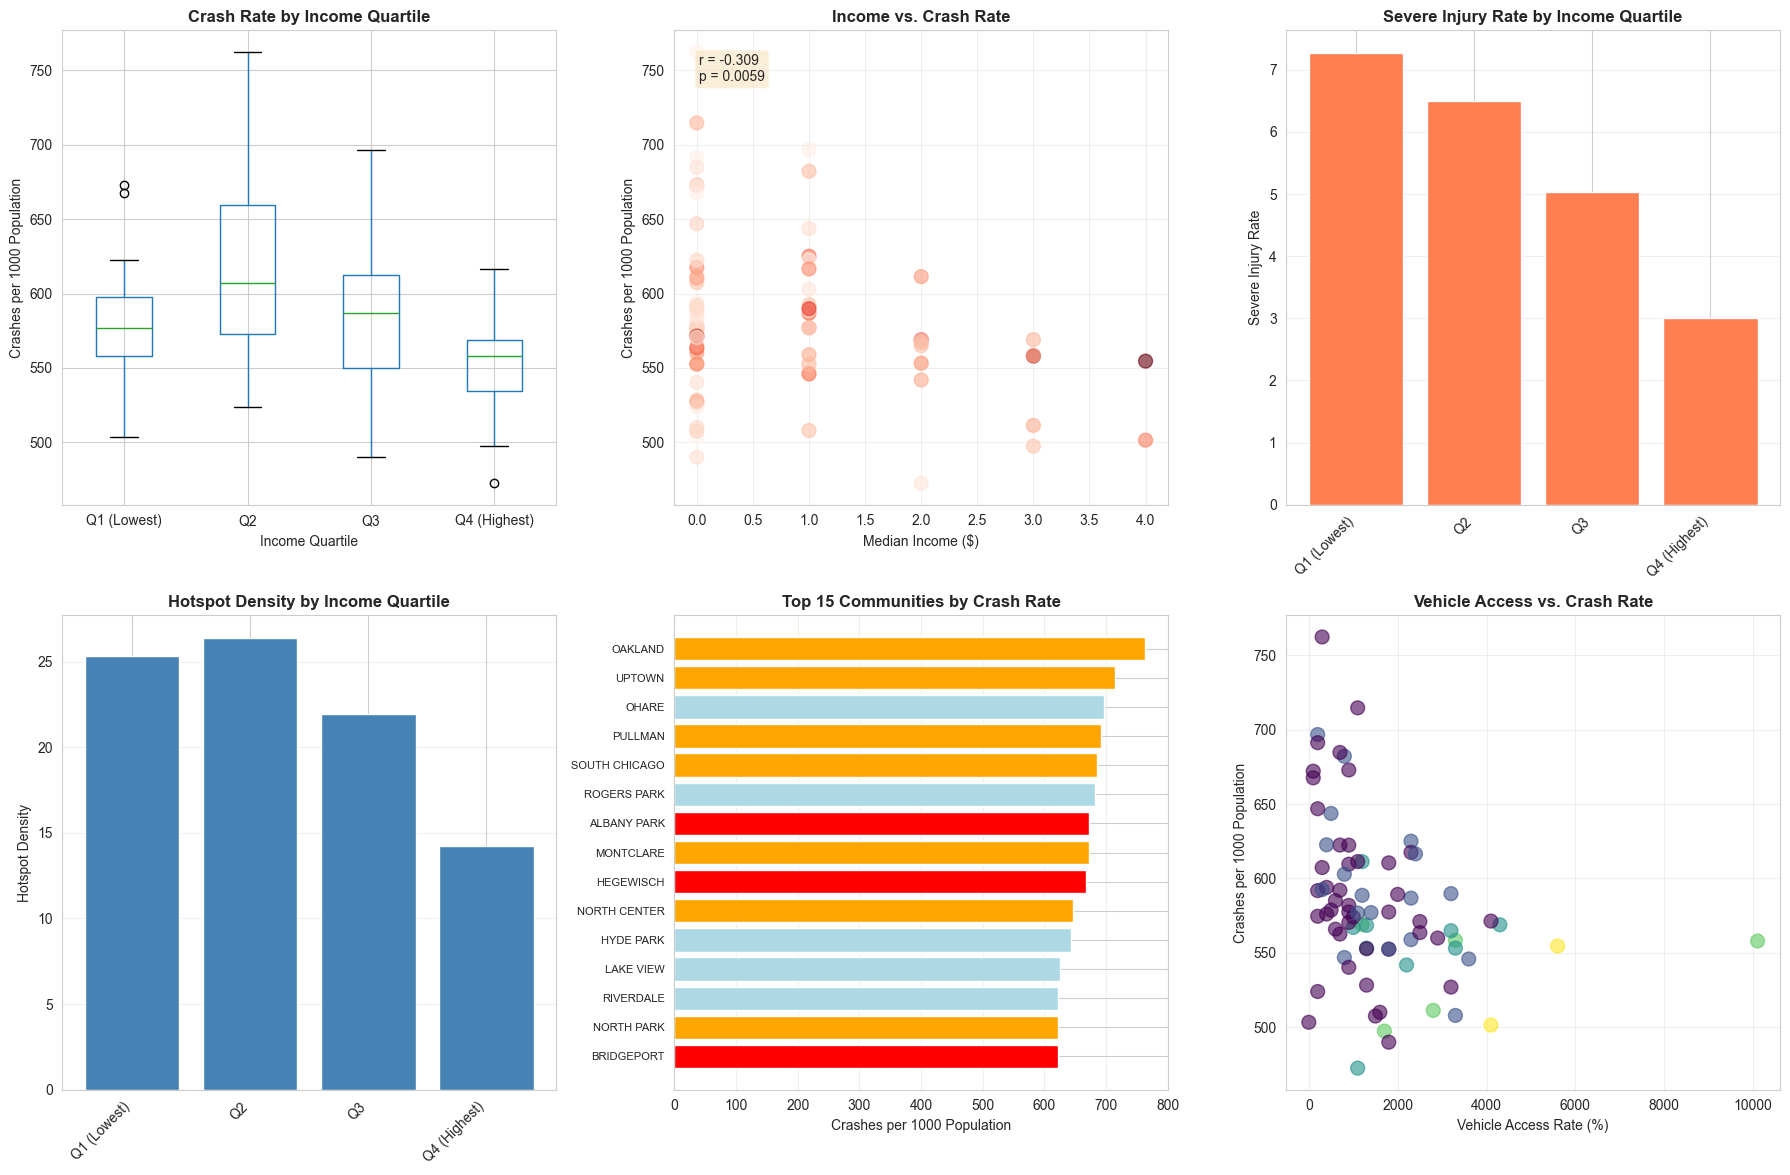

In [42]:
# Create comprehensive inequality visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Crash rate by income quartile (box plot)
community_stats.boxplot(
    column='crashes_per_1000_pop', 
    by='income_quartile', 
    ax=axes[0, 0]
)
axes[0, 0].set_title('Crash Rate by Income Quartile', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Income Quartile', fontsize=10)
axes[0, 0].set_ylabel('Crashes per 1000 Population', fontsize=10)
axes[0, 0].get_figure().suptitle('')  # Remove auto title

# 2. Scatter: Income vs Crash Rate
axes[0, 1].scatter(
    community_stats['avg_median_income'], 
    community_stats['crashes_per_1000_pop'],
    alpha=0.6, s=100, c=community_stats['total_crashes'], cmap='Reds'
)
axes[0, 1].set_xlabel('Median Income ($)', fontsize=10)
axes[0, 1].set_ylabel('Crashes per 1000 Population', fontsize=10)
axes[0, 1].set_title('Income vs. Crash Rate', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Add correlation text
axes[0, 1].text(
    0.05, 0.95, f'r = {corr_income_crashes:.3f}\np = {p_corr_crashes:.4f}',
    transform=axes[0, 1].transAxes, fontsize=10,
    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)

# 3. Severe injury rate by income quartile (if available)
if 'severe_injury_rate' in community_stats.columns and community_stats['severe_injury_rate'].notna().any():
    quartile_severity = community_stats.groupby('income_quartile')['severe_injury_rate'].mean()
    axes[0, 2].bar(range(len(quartile_severity)), quartile_severity.values, color='coral')
    axes[0, 2].set_xticks(range(len(quartile_severity)))
    axes[0, 2].set_xticklabels(quartile_severity.index, rotation=45, ha='right')
    axes[0, 2].set_ylabel('Severe Injury Rate', fontsize=10)
    axes[0, 2].set_title('Severe Injury Rate by Income Quartile', fontsize=12, fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3, axis='y')
else:
    # Show total crashes instead
    quartile_crashes = community_stats.groupby('income_quartile')['total_crashes'].sum()
    axes[0, 2].bar(range(len(quartile_crashes)), quartile_crashes.values, color='coral')
    axes[0, 2].set_xticks(range(len(quartile_crashes)))
    axes[0, 2].set_xticklabels(quartile_crashes.index, rotation=45, ha='right')
    axes[0, 2].set_ylabel('Total Crashes', fontsize=10)
    axes[0, 2].set_title('Total Crashes by Income Quartile', fontsize=12, fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Hotspot density by income quartile
quartile_hotspots = community_stats.groupby('income_quartile')['hotspot_density'].mean()
axes[1, 0].bar(range(len(quartile_hotspots)), quartile_hotspots.values, color='steelblue')
axes[1, 0].set_xticks(range(len(quartile_hotspots)))
axes[1, 0].set_xticklabels(quartile_hotspots.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Hotspot Density', fontsize=10)
axes[1, 0].set_title('Hotspot Density by Income Quartile', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 5. Top 15 communities by crash rate
top_15 = community_stats.nlargest(15, 'crashes_per_1000_pop')
colors = ['red' if q == 'Q1 (Lowest)' else 'orange' if q == 'Q2' else 'lightblue' 
          for q in top_15['income_quartile']]
axes[1, 1].barh(range(len(top_15)), top_15['crashes_per_1000_pop'].values, color=colors)
axes[1, 1].set_yticks(range(len(top_15)))
axes[1, 1].set_yticklabels(top_15['community_name'].values, fontsize=8)
axes[1, 1].set_xlabel('Crashes per 1000 Population', fontsize=10)
axes[1, 1].set_title('Top 15 Communities by Crash Rate', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

# 6. Vehicle access vs crash rate
axes[1, 2].scatter(
    community_stats['avg_vehicle_access_rate'] * 100,
    community_stats['crashes_per_1000_pop'],
    alpha=0.6, s=100, c=community_stats['avg_median_income'], cmap='viridis'
)
axes[1, 2].set_xlabel('Vehicle Access Rate (%)', fontsize=10)
axes[1, 2].set_ylabel('Crashes per 1000 Population', fontsize=10)
axes[1, 2].set_title('Vehicle Access vs. Crash Rate', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'inequality_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Saved: results/inequality_analysis.png")
plt.show()

## 7. Save Results

In [43]:
# Save community statistics
community_stats.to_csv(RESULTS_DIR / 'community_inequality_stats.csv', index=False)

# Save quartile summary
quartile_summary.to_csv(RESULTS_DIR / 'income_quartile_summary.csv')

# Save statistical test results
test_results = pd.DataFrame([
    {
        'test': 'ANOVA (crash rate by income quartile)',
        'statistic': f_stat,
        'p_value': p_value_anova,
        'significant': p_value_anova < 0.05
    },
    {
        'test': 'Correlation (income vs crash rate)',
        'statistic': corr_income_crashes,
        'p_value': p_corr_crashes,
        'significant': p_corr_crashes < 0.05
    },
    {
        'test': 'T-test (Q1 vs Q4 crash rates)',
        'statistic': t_stat,
        'p_value': p_ttest,
        'significant': p_ttest < 0.05
    }
])
test_results.to_csv(RESULTS_DIR / 'inequality_statistical_tests.csv', index=False)

print("\n✅ All inequality analysis results saved to results/ directory")
print("   - community_inequality_stats.csv")
print("   - income_quartile_summary.csv")
print("   - inequality_statistical_tests.csv")
print("   - inequality_analysis.png")


✅ All inequality analysis results saved to results/ directory
   - community_inequality_stats.csv
   - income_quartile_summary.csv
   - inequality_statistical_tests.csv
   - inequality_analysis.png


## Summary

This notebook provides evidence for crash inequality across Chicago communities by:

1. **Quantifying disparities** - Crash rates per capita by community area
2. **Testing significance** - ANOVA, correlations, t-tests
3. **Identifying patterns** - Income quartile analysis
4. **Visualizing inequality** - Multiple perspectives on crash burden

### Key Findings (to be filled after running):
- Are crash rates significantly different across income quartiles?
- Is there a correlation between neighborhood income and crash exposure?
- Which communities bear the highest crash burden?
- Do severe injuries follow the same pattern?

### For Your Paper:
Use these results in your **Results** and **Discussion** sections to address the "inequality" component of your project title.